# OCBA-m

Source. Chen et al. (2008) 

Efficient Simulation Budget Allocation for Selecting an Optimal Subset


https://pubsonline.informs.org/doi/pdf/10.1287/ijoc.1080.0268

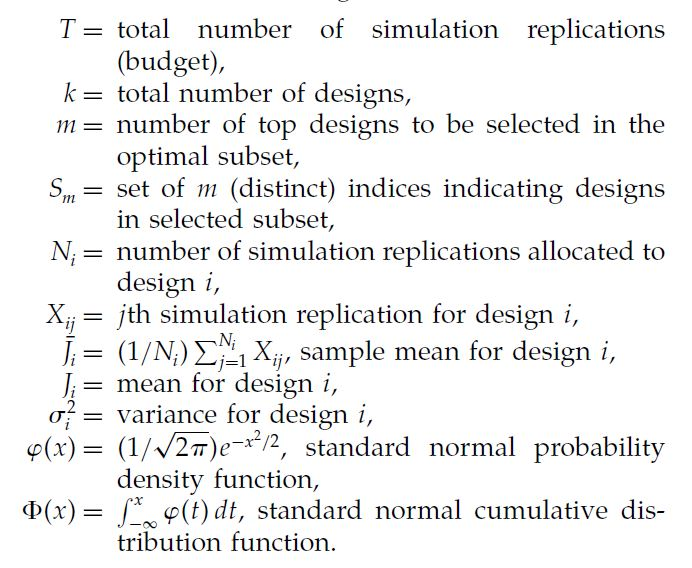

In [21]:
from IPython.display import Image
Image(filename= "images/definitions.jpg")

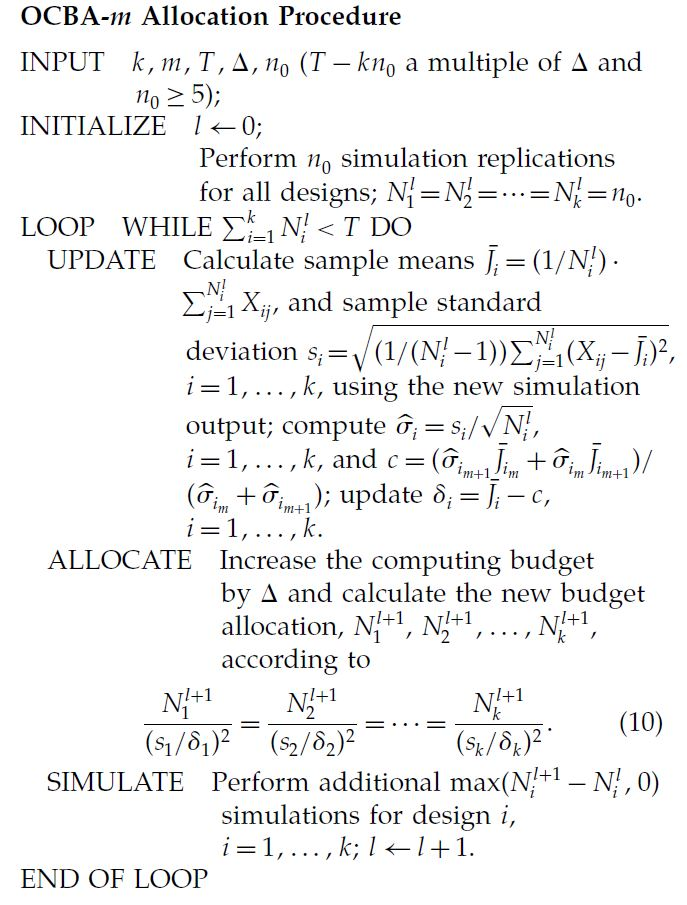

In [22]:
Image(filename= "images/procedure.jpg")

In [23]:
import pandas as pd
import numpy as np
import math

## Utility funcs

In [122]:
def load_system(file_name, system, reps, reps_available, delim=','):
    """
    Reads system data from a txt file (assumes comma delimited by default).  
    Assumes that each column represents a system.
    Returns a numpy array.  Each row is a system (single row); each col is a replication
    
    
    @file_name = name of file containing csv data
    @system = index of system in txt file.
    @reps = replications wanted
    @reps_available = total number of replications that has been simulated.
    @delim = delimiter of file.  Default = ',' for CSV.  

    """
    
    return np.genfromtxt(file_name, delimiter=delim, usecols = system, skip_footer = (reps_available - reps))

In [244]:
def load_systems(file_name, delim=','):
    """
    Reads system data from a txt file (assumes comma delimited by default).  
    Assumes that each column represents a system.
    Returns a numpy array.  Each row is a system (single row); each col is a replication
    
    @file_name = name of file containing csv data
    @delim = delimiter of file.  Default = ',' for CSV.  

    """
    
    return np.genfromtxt(file_name, delimiter=delim).transpose()

In [241]:
def simulate(data, k, allocations):
    return [data[i][0:allocations[i]] for i in range(k)]
    

In [25]:
def simulate_old(allocations):
    """
    Simulates the systems.  
    Each system is allocated a different budget of replications
    
    Returns list of numpy arrays
    
    @allocations = numpy array.  budget of replications for the k systems 
    """
    x = [load_system(file_name = ifile_name, system = i,reps = allocations[i], reps_available=reps_available) 
         for i in range(k)]
    return x

In [26]:
def get_ranks(array):
    """
    Returns a numpy array containing ranks of numbers within a input numpy array
    e.g. [3, 2, 1] returns [2, 1, 0]
    e.g. [3, 2, 1, 4] return [2, 1, 0, 3]
        
    @array - numpy array (only tested with 1d)
        
    """
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    return ranks

##  Input

**k** = total number of designs

**m** = no. of top designs to select

**T** = total budget (replications)

**n_0** = l number of replications  (>=5)

**delta** - additional budget to allocate between each simulation  

*where T - k.n_0 is a multiple of delta*


In [124]:
k = 10
m = 3
T = 200
n_0 = 5
delta = 50

#specific to this implementation
ifile_name = 'data/EG1a.csv'
reps_available = 10000

### OCBA-m tutorial - single loop of the algorithm

The code below illustrates the implementation of OCBA-m with a single pass of the algorithm.

## Initialise

In [111]:
allocations = np.full(k, n_0, dtype=int)

In [112]:
systems = simulate(allocations)

In [30]:
#while the sim of the replications is less than the total budget - loop

In [31]:
#sample means, standard devs and standard errors
means = np.array([array.mean() for array in systems])
stds = np.array([array.std() for array in systems])
ses = np.divide(stds, np.sqrt(allocations))


In [32]:
means

array([  0.27111639,   2.98900894,  -0.75878597,   6.44571837,
         4.87668767,   1.67743377,   6.07198807,   6.39908884,
        11.02499323,  10.25790571])

In [33]:
#calculate paramater c and gammas
c = ((ses[m+1] * means[m]) + (ses[m] * means[m+1]))/(ses[m]+ses[m+1])
gammas = means - c

calculate c 

In [34]:
c

5.9078444588870243

In [35]:
gammas

array([-5.63672807, -2.91883552, -6.66663043,  0.53787391, -1.03115679,
       -4.23041068,  0.16414361,  0.49124438,  5.11714877,  4.35006125])

## Allocate 

allocate additional budget **delta**

Procedure:

1. calculate N_i/(se_i * gamma_i)

2. while additional budget delta is available

    2.1 rank

    2.2 add 1 to smallest 

    2.3 delta =- 1


In [36]:
values = np.divide(allocations, np.square(np.divide(ses, gammas)))

for i in range(delta):

    ranks = get_ranks(values)
    values[ranks.argmin()] += 1
    allocations[ranks.argmin()] += 1



In [37]:
allocations

array([ 5,  5,  5, 17, 17,  5, 18, 18,  5,  5])

## Simulate

Simulate the next stage...

In [38]:
systems = simulate(allocations)
means2 = np.array([array.mean() for array in systems])
print(np.subtract(means2, means))

[ 0.          0.          0.         -1.6639798  -2.83279347  0.
 -1.23251199  0.09621221  0.          0.        ]


and continue looping until budget is all used up...

### Full implementation 

In [39]:
def summary_statistics(systems, allocations):
    means = np.array([array.mean() for array in systems])
    stds = np.array([array.std() for array in systems])
    ses = np.divide(stds, np.sqrt(allocations))
    return means, ses

In [49]:
def top_m(means, m):
    ranks = get_ranks(means)
    return np.argpartition(ranks, -m)[-m:]
     

In [229]:
def ocba_m(systems, allocations, T):
    while allocations.sum() < T:
       
        #calculate sample means and standard errors
        means, ses = summary_statistics(systems, allocations)

        #calculate paramater c and gammas
        c = ((ses[m+1] * means[m]) + (ses[m] * means[m+1]))/(ses[m]+ses[m+1])
        gammas = means - c

        #new allocation
        values = np.divide(allocations, np.square(np.divide(ses, gammas)))

        for i in range(delta):
            ranks = get_ranks(values)
            values[ranks.argmin()] += 1
            allocations[ranks.argmin()] += 1

        #simulate systems using new allocation of budget
        systems = simulate(data, k, allocations)
        
    means, ses = summary_statistics(systems, allocations)
    return means, ses, allocations

In [42]:
allocations = np.full(k, n_0, dtype=int)
systems = simulate(allocations)

means, ses, allocations = ocba_m(systems, allocations)

print(means)
print(allocations)



[ -2.60158078   0.70954124   1.2663153    2.62853148   3.60132775
   4.30663444   5.64572938   7.0481237   11.02499323  10.74838085]
[ 19  92 122 269 269 113  54  40   5  17]


In [65]:
selected_top_m = top_m(means, m)
true_top_m = np.array([7, 8, 9])

true_means = np.arange(1, 11)



True

In [76]:
def cs(selected_top_m, true_top_m):
    """
    Returns boolean value.  
    True = correct selection of top m
    False = incorrect selection (one or more of selected top m is incorrect)
    
    @selected_top_m - numpy.array containing the indexes of the top m means selected by the algorithm
    @true_top_m - numpy.array containing the indexes of the true top m means
    
    """
    return np.array_equal(selected_top_m, true_top_m)

In [73]:
def oc(true_means, selected_top_m, true_top_m):
    """
    Return the opportunity cost of the selection
    Method penalised particular bad solutions more than mildly bad
    
    @true_means - numpy.array of true means
    @selected_top_m - numpy.array containing the indexes of the top m means selected by the algorithm
    @true_top_m - numpy.array containing the indexes of the true top m means
    
    """
    return (true_means[selected_top_m] - true_means[true_top_m]).sum()

In [271]:
def p_cs(correct_selections):
    """
    Returns the probability of correct selection P{cs}
    
    @correct_selections - list indicating if a given budget found the top m e.g. [False, True, True]
    """
    return np.array(correct_selections).sum() / len(correct_selections)

In [272]:
def e_oc(opportunity_costs):
    """
    Return the expected opportunity cost E{oc}
    
    @opportunity costs - arrange of opportunity cost per budget
    """
    return np.array(opportunity_costs).mean()

In [157]:
def min_top_m(means, m):
    ranks = get_ranks(means)
    return np.argpartition(ranks, m)[:m]

# Numerical test

In [256]:
k = 10
m = 3
T = 4000
n_0 = 20
delta = 50

#specific to this implementation
ifile_name = 'data/EG2a.csv'
reps_available = 10000

#info for correct selection
true_top_m = np.array([7, 8, 9])

true_means = np.arange(1, 11)

budgets = [i for i in range(200, T + 200, 200)]

In [274]:
#loop through budgets

correct_selections = []
opportunity_costs = []

data = load_systems(ifile_name)

for t in budgets:
    
    allocations = np.full(k, n_0, dtype=int)
    systems = simulate(data, k, allocations)

    means, ses, allocations = ocba_m(systems, allocations, t)
    selected_top_m = top_m(means, m)
    
    correct_selections.append(cs(selected_top_m, true_top_m))
    opportunity_costs.append(oc(true_means, selected_top_m, true_top_m))
    
print("P(cs): {0}".format(p_cs(correct_selections)))
print("E(OC): {0}".format(e_oc(opportunity_costs)))


P(cs): 0.85
E(OC): -0.15
